## HW7 B989006 권오승

# 1. Learning a classifier for the “Imbalanced Iris” Data Set – Part II
### 1.1.  Discretize the Iris data set into three bins. Then use the DecisionTreeClassifier with a 10-fold stratified cross validation and compute the accuracy. Afterwards plot the decision tree.

In [146]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

data = pd.read_csv('iris_imbalanced.csv',header='infer')
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [147]:
for i in data.Name.values:
    if i == 'Iris-setosa':
        data.Name.replace(i,0,inplace=True)
    elif i == 'Iris-virginica':
        data.Name.replace(i,1,inplace=True)
    elif i == 'Iris-versicolor':
        data.Name.replace(i,2,inplace=True)
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 1.1.1. Use DecisionTreeClassfier(with max_depth)

In [151]:
feature = data.drop('Name',axis=1)
label = data['Name']
dt = tree.DecisionTreeClassifier(max_depth=2,random_state=1124)
dt

DecisionTreeClassifier(max_depth=2, random_state=1124)

### 1.1.2. 10-fold stratified cross validation & Compute the accuracy

In [152]:
# 10-fold stratified cross validation
score = cross_val_score(dt,feature,label,scoring='accuracy',cv=10)
# Compute the accuracy¶
print('mean score accuracy:', score.mean())

mean score accuracy: 0.9685714285714285


### 1.1.3. plot the decision tree

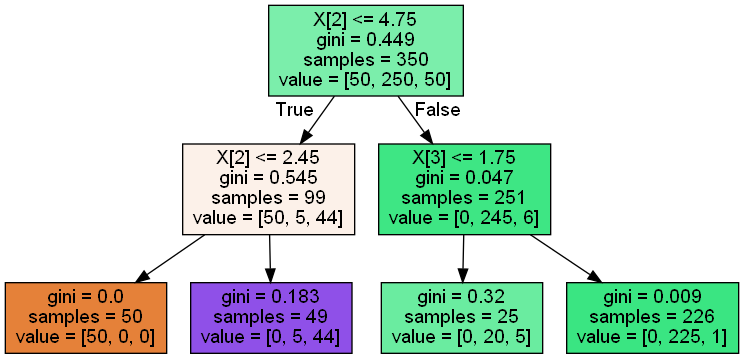

In [153]:
import pydotplus
from IPython.display import Image
dt.fit(feature,label)
dot_data = tree.export_graphviz(dt,filled=True, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### 1.2. Remove the discretization and adjust the max_depth parameter of DecisionTreeClassifier to increase the accuracy. 
### Does the accuracy change? Compare the complexity of the two models. 

In [155]:
data = pd.read_csv('iris_imbalanced.csv',header='infer')
feature = data.drop('Name',axis=1)
label = data['Name']
dt = tree.DecisionTreeClassifier(random_state=1124)

In [156]:
# 10-fold stratified cross validation
score = cross_val_score(dt,feature,label,scoring='accuracy',cv=10)
# Compute the accuracy¶
print('mean score accuracy:', score.mean())

mean score accuracy: 0.9885714285714287


accuracy가 0.96에서 0.98로 증가하였다.
max_depth가 없는 모델은 default 값이 None으로,
None인 상태에서는 의사결정나무의 가지를 끝까지 확장하게 된다.

따라서, max_depth가 없는 모델의 정확도가 더 증가하게 된다.

___
# 2. Who should get a bank credit?

### 2.1. Plot ROC curves for k-NN (different k values) and Decision Tree (you can use the given avg_roc function) . Which classification approach looks most promising to you?

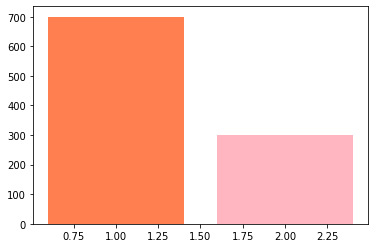

In [4]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter


names=[('Attribute '+str(i)) for i in range(1,21)]
names.append('class')
credit = pd.read_csv("german.data",sep=' ',header=None,names=names)
credit.head()

# separate the target variable from the features
credit_target = credit['class']

credit_data = credit.drop('class', axis=1)

# plot the class distribution
c = ['good','bad']
counter = Counter(credit_target)
plt.bar(counter.keys(), counter.values(),color=['coral','lightpink'])
plt.show()

In [5]:
for i in credit_target.values:
    if i == 2:
        credit_target.replace(i,0,inplace=True)

In [6]:
credit_data.select_dtypes(include=['int64', 'float64']).columns

Index(['Attribute 2', 'Attribute 5', 'Attribute 8', 'Attribute 11',
       'Attribute 13', 'Attribute 16', 'Attribute 18'],
      dtype='object')

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# think about which features you want to re-scale, encode using one-hot encoding or encode using ordinal encoding
# then, create a ColumnTransformer to execute this preprocessing for you
cat_ix = credit_data.select_dtypes(include=['object', 'bool']).columns
num_ix = credit_data.select_dtypes(include=['int64', 'float64']).columns

# one hot encode cat features only
preprocessor = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',StandardScaler(),num_ix)])

Run the following cell once to define the ```avg_roc``` function:

In [8]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from scipy import interp
from sklearn.metrics import roc_curve, auc

def avg_roc(cv, estimator, data, target,classifier):
    print(estimator['estimator'])

    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)
        test_data = data.iloc[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)
    
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1]) #, pos_label=pos_label
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        if(classifier==KNeighborsClassifier):
            plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

The evaluate different classifiers using the ```avg_roc``` function and plot the results:

KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
KNeighborsClassifier()
DecisionTreeClassifier()
GaussianNB()


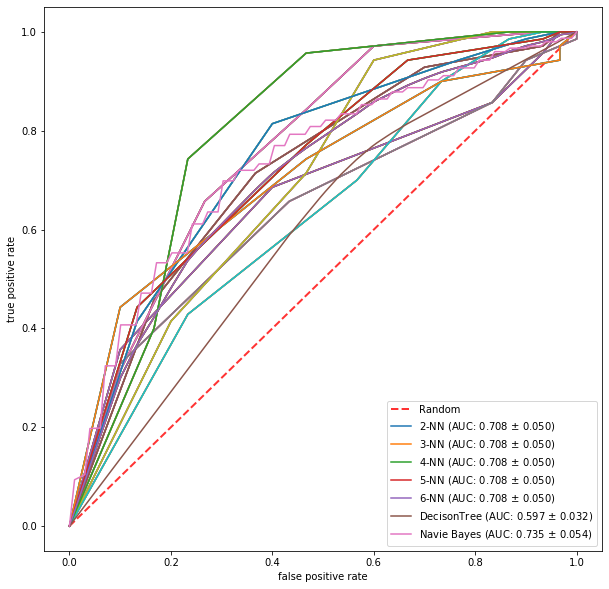

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
classifier = KNeighborsClassifier()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
# setup a figure
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8) # draw diagonal

# KNN
for n_neighbour in [2,3,4,5,6]:
    #TODO: INSERT YOUR CODE HERE!
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data, credit_target,KNeighborsClassifier)
    plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))

# Decision Tree
classifier = DecisionTreeClassifier()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data,credit_target,DecisionTreeClassifier)
plt.plot(mean_fpr, mean_tpr, label='DecisonTree (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

# Naive Bayes
classifier = GaussianNB()
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', classifier) ])
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data,credit_target,GaussianNB)
plt.plot(mean_fpr, mean_tpr, label='Navie Bayes (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))


# show the plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

### 2.2.	For the two most promising classification approaches, compute the accuracy and confusion matrix in a 10-fold CV setup. Which level of accuracy do you reach?

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(credit_data,credit_target,stratify=credit_target,test_size=0.2,random_state=1)

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ Decision Tree ]

accuracy 0.6762499999999999


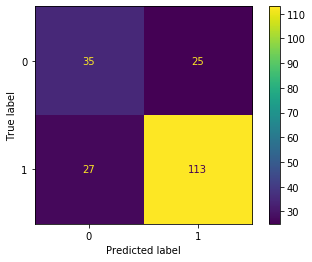

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)


predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ KNN ]

accuracy 0.7337499999999999


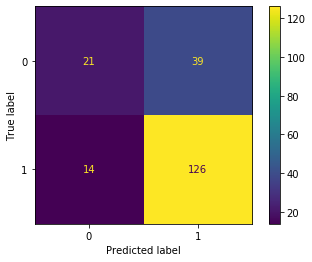

In [15]:
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)

predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ Naive Bayer ]

accuracy 0.49375


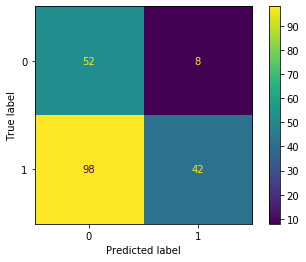

In [16]:
# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=10)

pipeline.fit(X_train,y_train)
plot_confusion_matrix(pipeline,X_test,y_test)

predY = pipeline.predict(X_test)
print('accuracy',scores.mean())

### 2.3.	What do the precision and recall values for the class “bad”  tell you? Try to improve the situation by increasing the number of “bad” examples in the training set (in the cross validation). How do precision and recall change if you apply this procedure? 

* before resampling

In [17]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

credit_target.value_counts() # 1: 'good', 0: 'bad'

1    700
0    300
Name: class, dtype: int64

* after resampling(random oversampling)

In [18]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

sm = RandomOverSampler()

X_resampled, y_resampled = sm.fit_resample(credit_data,credit_target)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled,y_resampled,stratify=y_resampled,test_size=0.2,random_state=1)

y_resampled.value_counts()

1    700
0    700
Name: class, dtype: int64

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ Decision Tree ] (after resampling)

accuracy 0.8116071428571429


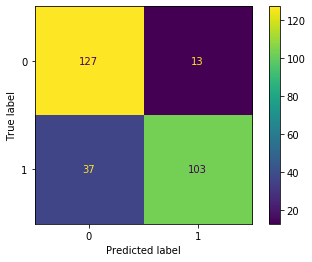

In [19]:
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ KNN ] (after resampling)

accuracy 0.7169642857142857


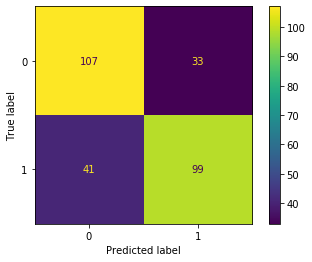

In [39]:

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

#### compute the accuracy and confusion matrix in a 10-fold CV setup [ Naive Bayer ] (after resampling)

accuracy 0.68125


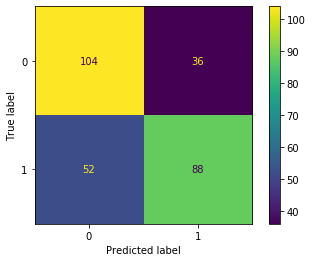

In [40]:
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
scores = cross_val_score(pipeline,X_train1 , y_train1, scoring='accuracy', cv=10)

pipeline.fit(X_train1,y_train1)
plot_confusion_matrix(pipeline,X_test1,y_test1)

predY = pipeline.predict(X_test1)
print('accuracy',scores.mean())

### 2.4.	To model a use case specific evaluation, compute the cost of all missclassifications. Set up your cost matrix by assuming that you will lose 1 Unit if you refuse a credit to a good customer, but that you lose 100 Units if you give a bad customer a credit. Rerun the experiments and evaluate the results.

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

#### compute the cost of all missclassifications [ DecisionTree ]

In [42]:
# create the predictions here
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
pipeline.fit(X_train,y_train)

prediction = cross_val_predict(pipeline, X_train, y_train, cv=10)
predY = pipeline.predict(X_test)
accuracy_score(y_test,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test, predY)
print("DecisionTreeClassifier with accuracy of {} and cost {}".format(acc, cost))

DecisionTreeClassifier with accuracy of 0.72 and cost 14439


#### compute the cost of all missclassifications [ 6-NN ]

In [43]:
# create the predictions here
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier(n_neighbors = 6, p=2)) ])
pipeline.fit(X_train,y_train)

prediction = cross_val_predict(pipeline, X_train, y_train, cv=10)
predY = pipeline.predict(X_test)
accuracy_score(y_test,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test, predY)
print("6-NN with accuracy of {} and cost {}".format(acc, cost))

6-NN with accuracy of 0.74 and cost 13886


#### compute the cost of all missclassifications [ Naive Bayer ]

In [52]:
# create the predictions here
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
pipeline.fit(X_train,y_train)

prediction = cross_val_predict(pipeline, X_train, y_train, cv=10)
predY = pipeline.predict(X_test)
accuracy_score(y_test,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test, predY)
print("Naive Bayer with accuracy of {} and cost {}".format(acc, cost))

Naive Bayer with accuracy of 0.47 and cost 2880


___
#### compute the cost of all missclassifications [ Decisison Tree ] (after resampling)

In [55]:
# create the predictions here
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
pipeline.fit(X_train1,y_train1)

prediction = cross_val_predict(pipeline, X_train1, y_train1, cv=10)
predY = pipeline.predict(X_test1)
accuracy_score(y_test1,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train1, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test1, predY)
print("DecisionTreeClassifier with accuracy of {} and cost {}".format(acc, cost))

DecisionTreeClassifier with accuracy of 0.8428571428571429 and cost 6141


#### compute the cost of all missclassifications [ 6-NN ] (after resampling)

In [53]:
# create the predictions here
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', KNeighborsClassifier(n_neighbors = 6, p=2)) ])
pipeline.fit(X_train1,y_train1)

prediction = cross_val_predict(pipeline, X_train1, y_train1, cv=10)
predY = pipeline.predict(X_test1)
accuracy_score(y_test1,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train1, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test1, predY)
print("6-NN with accuracy of {} and cost {}".format(acc, cost))

6-NN with accuracy of 0.725 and cost 12217


#### compute the cost of all missclassifications [ Naive Bayer ] (after resampling)

In [51]:
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', GaussianNB()) ])
pipeline.fit(X_train1,y_train1)

prediction = cross_val_predict(pipeline, X_train1, y_train1, cv=10)
predY = pipeline.predict(X_test1)
accuracy_score(y_test1,predY)
# You can use the following code to calculate the cost
cm = confusion_matrix(y_train1, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test1, predY)
print("Naive Bayer with accuracy of {} and cost {}".format(acc, cost))
# -----

Naive Bayer with accuracy of 0.6857142857142857 and cost 12534


___
## 3. (Parameter Tuning) Who should get a bank credit?
### 3.1. What were the default parameters of the Decision Tree algorithm used in Question #2?

max_depth가 없는 모델은 default 값이 None으로, None인 상태에서는 의사결정나무의 가지를 끝까지 확장하게 된다.
즉, 완벽하게 클래스 값이 결정될 때 까지 분할하거나 데이터 개수가 min_samples_split보다 작아질 때까지 분할한다.
<p>=> 하지만, 이로 인해 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어가 필요하다.

### 3.2. Now try to find a more appropriate configuration for the Decision Tree classifier. Use the GridSearchCV from scikit-learn. Try the following parameters of the Decision Tree:
-	criterion: ['gini', 'entropy']
-	'max_depth': [1, 2, 3, 4, 5, None] (What does None mean?)
-	'min_samples_split': [2,3,4,5]

You should come up with 48 (2 x 6 x 4) combinations. 
What is the best configuration for the data set and the classification approach?


In [73]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', DecisionTreeClassifier()) ])
pipeline.fit(X_train1,y_train1)
# 지니계수:
# 엔트로피: 
param_dict = {
"estimator__criterion":['gini','entropy'],
    "estimator__min_samples_split":[2,3,4,5],
    'estimator__max_depth': [1,2,3,4,5,None]
}
grid = GridSearchCV(pipeline,
                   param_grid=param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)
grid.fit(X_train1,y_train1)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('c',
                                                                         OneHotEncoder(),
                                                                         Index(['Attribute 1', 'Attribute 3', 'Attribute 4', 'Attribute 6',
       'Attribute 7', 'Attribute 9', 'Attribute 10', 'Attribute 12',
       'Attribute 14', 'Attribute 15', 'Attribute 17', 'Attribute 19',
       'Attribute 20'],
      dtype='object')),
                                                                        ('n',
                                                                         StandardScaler(),
                                                                         Index(['Attribute 2', 'Attribute 5', 'Attribute 8', 'Attribute 11',
       'Attribute 13', 'Attribute 16', 'Attribute 18'],
      dtype='object'))])),
                                  

In [143]:
result = pd.DataFrame(grid.cv_results_['params'])
result['mean_test_score'] = grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,estimator__criterion,estimator__max_depth,estimator__min_samples_split,mean_test_score
44,entropy,NaN,2,0.821429
20,gini,NaN,2,0.814286
21,gini,NaN,3,0.813393
45,entropy,NaN,3,0.810714
46,entropy,NaN,4,0.808929
22,gini,NaN,4,0.807143
47,entropy,NaN,5,0.803571
23,gini,NaN,5,0.797321
42,entropy,5.0,4,0.700000
43,entropy,5.0,5,0.700000


위의 표에서 index는 0부터 47까지로 총 48개의 데이터가 존재한다.
<p>최대값은 entropy를 사용하고 max_depth: None, min_sample_split: 2를 가지고 있는 0.821이다.

### 3.3. What is the cost of misclassification for this configuration?

In [141]:
best_grid = grid.best_estimator_
prediction = cross_val_predict(best_grid, X_train, y_train, cv=10)

predY = best_grid.predict(X_test)
accuracy_score(y_test,predY)
cm = confusion_matrix(y_train, prediction)
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(y_test, predY)
print("DecisionTreeClassifier with accuracy of {} and cost {}".format(acc, cost))

DecisionTreeClassifier with accuracy of 0.94 and cost 13033


### 3.4. How does the optimal decision tree differ from the one you have learned in Question 2.4

Question 2.4에서의 의사결정나무는 14439의 오분류률과 0.843의 예측 정확도를 보여주었는데,
최적의 의사결정나무에서는 13033의 오분류률과 0.94의 예측 정확도를 보여주었다.
따라서, 최적의 의사결정나무의 정확도가 더 높게 나오고, 오분류률또한 더 적다는 것을 알 수 있다.